## Update sagemaker package

In [ ]:
!pip install sagemaker -U

## Import libs

In [ ]:
import os
import boto3
import sagemaker

bucket = sagemaker.Session().default_bucket()
prefix = "sagemaker-demo-20230220"

role = sagemaker.get_execution_role()

In [ ]:
! sudo chown -R $USER /home/ec2-user/SageMaker/lost+found

## Login to ECR, build docker image and push to ECR

In [ ]:
%%sh

algorithm_name=predversion1

#set -e # stop if anything fails
account=$(aws sts get-caller-identity --query Account --output text)

# Get the region defined in the current configuration (default to us-west-2 if none defined)
region=$(aws configure get region)
region=${region:-ap-southeast-1}
echo "$account"
echo "$region"
fullname="${account}.dkr.ecr.${region}.amazonaws.com/${algorithm_name}:latest"

# Get the login command from ECR and execute it directly
aws ecr get-login-password --region ${region} | docker login --username AWS --password-stdin ${account}.dkr.ecr.${region}.amazonaws.com

# If the repository doesn't exist in ECR, create it.
aws ecr describe-repositories --repository-names "${algorithm_name}" > /dev/null 2>&1

if [ $? -ne 0 ]
then
    aws ecr create-repository --repository-name "${algorithm_name}" > /dev/null
fi

# Build the docker image locally with the image name and then push it to ECR
# with the full name.
echo "start building image"
cat Dockerfile
docker build  -t ${algorithm_name} .
echo "start docker tag"
docker tag ${algorithm_name} ${fullname}

echo "start docker push"
docker push ${fullname}
echo "push successfully"

## You stop here and Go back to the Documentation

## Automation
## Create EventBridge Scheduler

In [ ]:
! pip install tzlocal

In [ ]:
import boto3
import datetime
from tzlocal import get_localzone
tz = get_localzone()
session = boto3.Session(
    region_name='ap-southeast-1'
)
client = session.client('scheduler')


In [ ]:
# Fill your ECR image URI and Role of Sagemaker instance notebook here (below are samples)
ecr_image_uri = "149138027712.dkr.ecr.ap-southeast-1.amazonaws.com/predversion1:latest" # sample
role_arn_of_sagemaker_execution = "arn:aws:iam::149138027712:role/service-role/AmazonSageMaker-ExecutionRole-20230219T175827" # sample

In [ ]:
# Edit StartDate in the function below
# StartDate is the time that your schedule will be effective from that date, 
# StartDate must be in the future from the time you run this code.

def create_schedule(schedule_name:str, atm_ids: str, instance_type: str):
    tem = '{\n    "AppSpecification": {\n      "ImageUri": "' + ecr_image_uri + '"\n    },\n    "ProcessingInputs": [\n      {\n        "AppManaged": false,\n        "InputName": "input",\n        "S3Input": { \n          "LocalPath": "/opt/ml/processing/input/",\n          "S3DataType": "S3Prefix",\n          "S3InputMode": "File",\n          "S3Uri": "s3://sagemaker-demo-20230220/input/"\n        }\n      }\n    ],\n    "ProcessingJobName": "scheduler-atm-wk-01",\n    "ProcessingOutputConfig": {\n      "Outputs": [\n        {\n          "AppManaged": false,\n          "OutputName": "output",\n          "S3Output": {\n            "LocalPath": "/opt/ml/processing/output/",\n            "S3UploadMode": "EndOfJob",\n            "S3Uri": "s3://sagemaker-demo-20230220/output/"\n          }\n        }\n      ]\n    },\n    "ProcessingResources": {\n      "ClusterConfig": {\n        "InstanceCount": 1,\n        "InstanceType": "'+ instance_type +'",\n        "VolumeSizeInGB": 1\n      }\n    },\n     "Environment" : {  "SIR": "' + atm_ids + '"  },\n    "RoleArn": "'+ role_arn_of_sagemaker_execution +'"\n  }',

    print(tem[0])
    response = client.create_schedule(
        ClientToken='string',
        Description= 'demo for bidv',
        EndDate=datetime.datetime(2023, 3, 12, 17, 0,  tzinfo=tz),
        FlexibleTimeWindow={'Mode': 'OFF'},
        GroupName='default',
        Name=schedule_name,
        ScheduleExpression='cron(00 8 ? * 1 2023)',
        ScheduleExpressionTimezone='Asia/Ho_Chi_Minh',
        StartDate= datetime.datetime(2023, 3, 1, 17, 0, tzinfo=tz),  # edit StartDate here, currently it is effective from 2023/02/29 at 17:00
        State='ENABLED',
        Target={
            'Arn': 'arn:aws:scheduler:::aws-sdk:sagemaker:createProcessingJob',
            'Input': tem[0],
            'RetryPolicy': 
                {
                    'MaximumEventAgeInSeconds': 86400,
                    'MaximumRetryAttempts': 0
                },
            'RoleArn': 'arn:aws:iam::149138027712:role/service-role/AmazonSageMaker-ExecutionRole-20230219T175827'
        }
    )

### Replace your ATM ID list here

In [ ]:
# An array of all ATM_id 
ATM_IDS = [990035,2000,2001,2002,2003,2004,2005,2006,2007,2008,
          990035,2000,2001,2002,2003,2004,2005,2006,2007,2008,
          990035,2000,2001,2002,2003]

In [ ]:
index = 0
mlt3large_quota = 100 #20
mlc5xlarge_quota = 16
mlc4xlarge_quota = 16
mlm5large_quota = 16
limit = len(ATM_IDS)

# Create schedule request rate quota = 50

while index < limit: # 200

    for instance_count in range(mlt3large_quota):
        if index >= limit:
            break
        if index + 1 < limit:
            atm_ids = f"{ATM_IDS[index]},{ATM_IDS[index+1]}" 
        else:
            atm_ids = f"{ATM_IDS[index]}" 
        # each ml.t3.large instance handle at most 2 ATMs.
        create_schedule(f"atm-weekly-{index}",atm_ids, instance_type = "ml.t3.large")
        index = index + 2
        print(atm_ids)
    print("done t3 l")

#     Uncomment this section if there are more than 200 ATMs.
#     for instance_count in range(mlm5large_quota):
#         if index >= limit:
#             break
#         if index + 1 < limit:
#             atm_ids = f"{ATM_IDS[index]},{ATM_IDS[index+1]}" 
#         else:
#             atm_ids = f"{ATM_IDS[index]}" 
#         create_schedule(f"atm-weekly-{index}",atm_ids, instance_type = "ml.m5.large")
#         index = index + 2
#         print(atm_ids)
#     print("done m5 l")




## Now you did finish your implementation, 
#### Check your EventBridge to see the results: something looks like below image

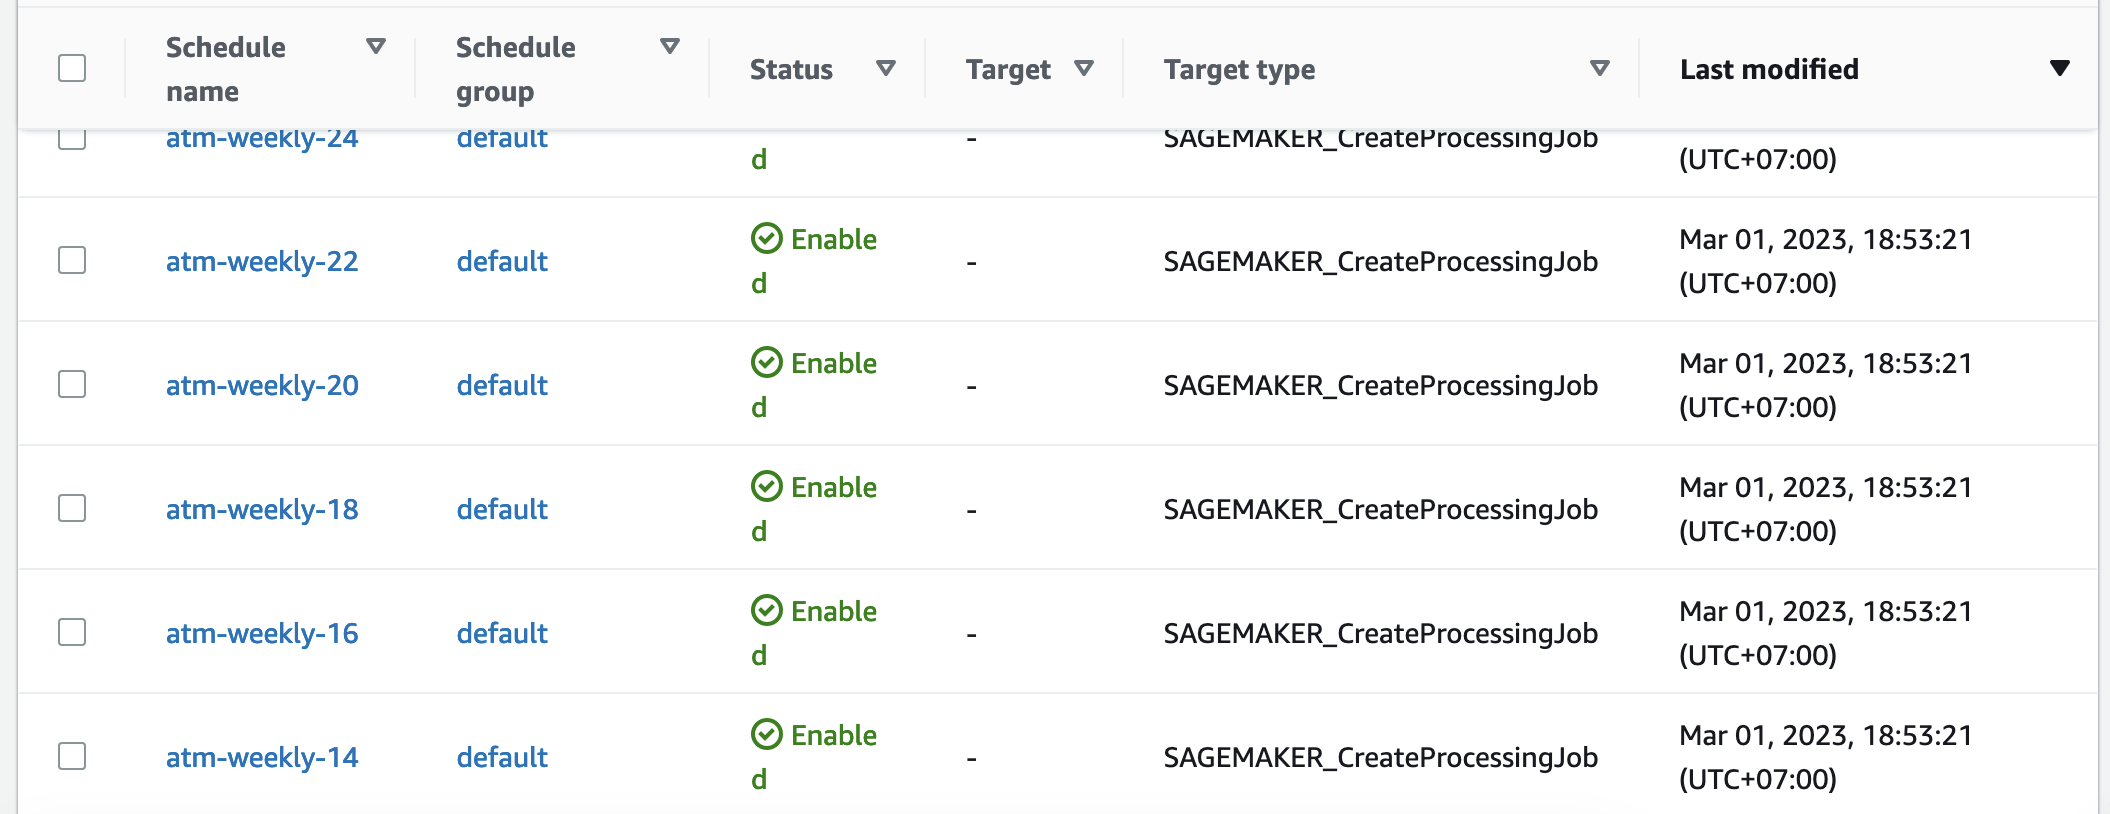

## Testing section

### SageMaker processing job test

#### In this part, you will create a sagemaker processing job and it will run immediately after you execute these two following code cells

In [ ]:
smclient = session.client("sagemaker")


In [ ]:
# Every time you run this cell, change processing_job_name value because each processing job needs different name !
processing_job_name = "predictCashATM-0301" 
request = {
    "AppSpecification": {
      "ImageUri": ecr_image_uri
    },
    "ProcessingInputs": [
      {
        "AppManaged": False,
        "InputName": "input",
        "S3Input": { 
          "LocalPath": "/opt/ml/processing/input/",
          "S3DataType": "S3Prefix",
          "S3InputMode": "File",
          "S3Uri": "s3://sagemaker-demo-20230220/input/"
        }
      }
    ],
    "ProcessingJobName": processing_job_name,
    "ProcessingOutputConfig": {
      "Outputs": [
        {
          "AppManaged": False,
          "OutputName": "output",
          "S3Output": {
            "LocalPath": "/opt/ml/processing/output/",
            "S3UploadMode": "EndOfJob",
            "S3Uri": "s3://sagemaker-demo-20230220/output/"
          }
        }
      ]
    },
    "ProcessingResources": {
      "ClusterConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.t3.large",
        "VolumeSizeInGB": 1
      }
    },
    "RoleArn": role_arn_of_sagemaker_execution
  }

# De-structure it into boto3:
smclient.create_processing_job(**request)

#### Check your SageMaker processing job to see the result


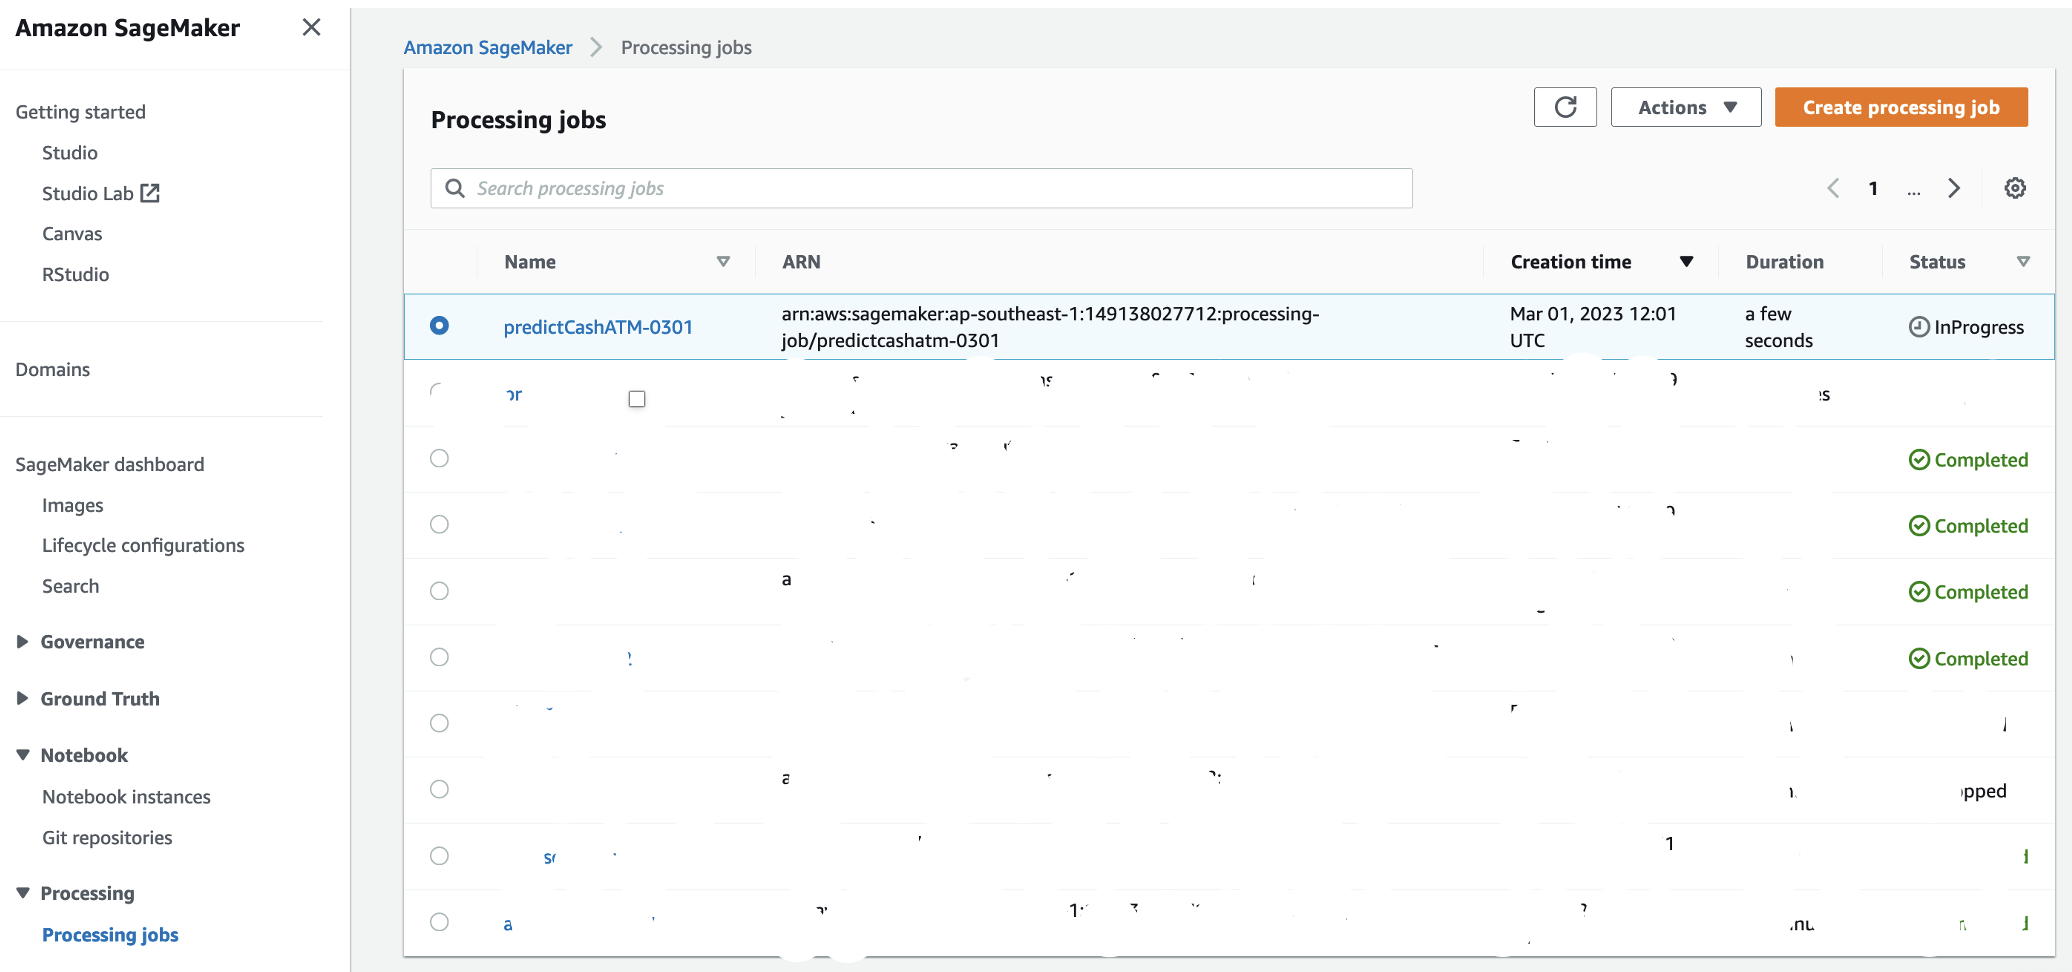

Click on job name to see its details
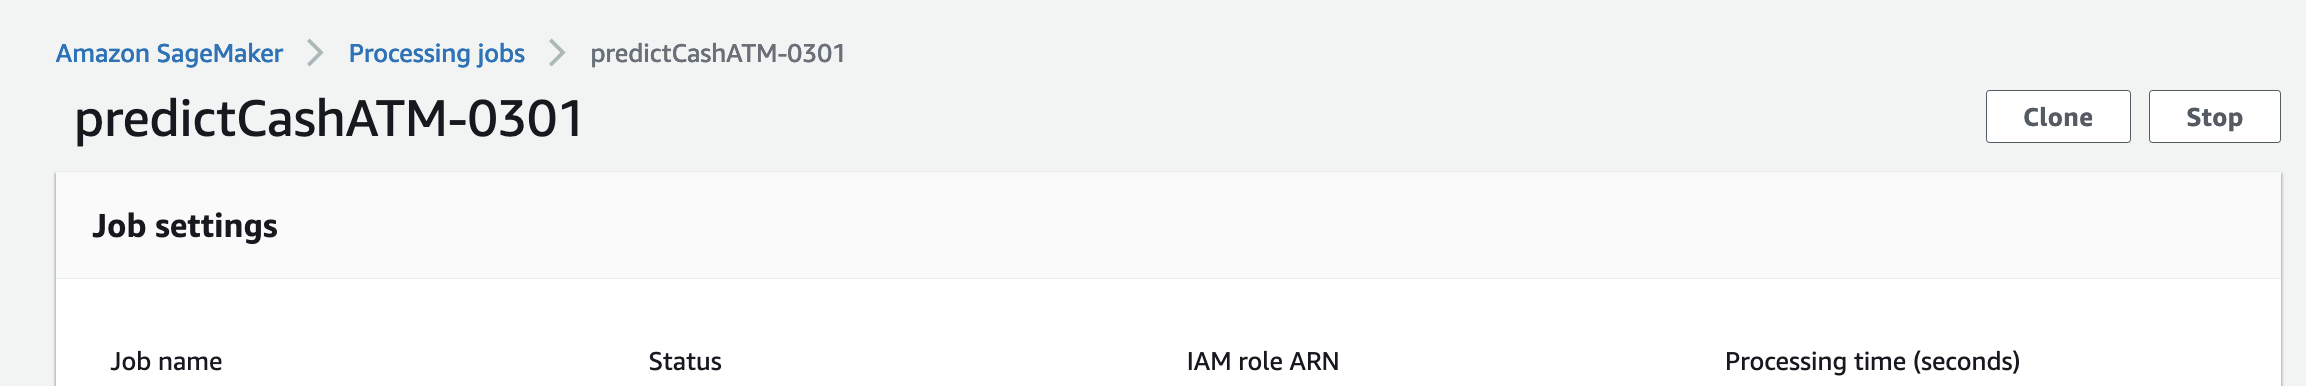

Scroll down and click "View logs" to see the log
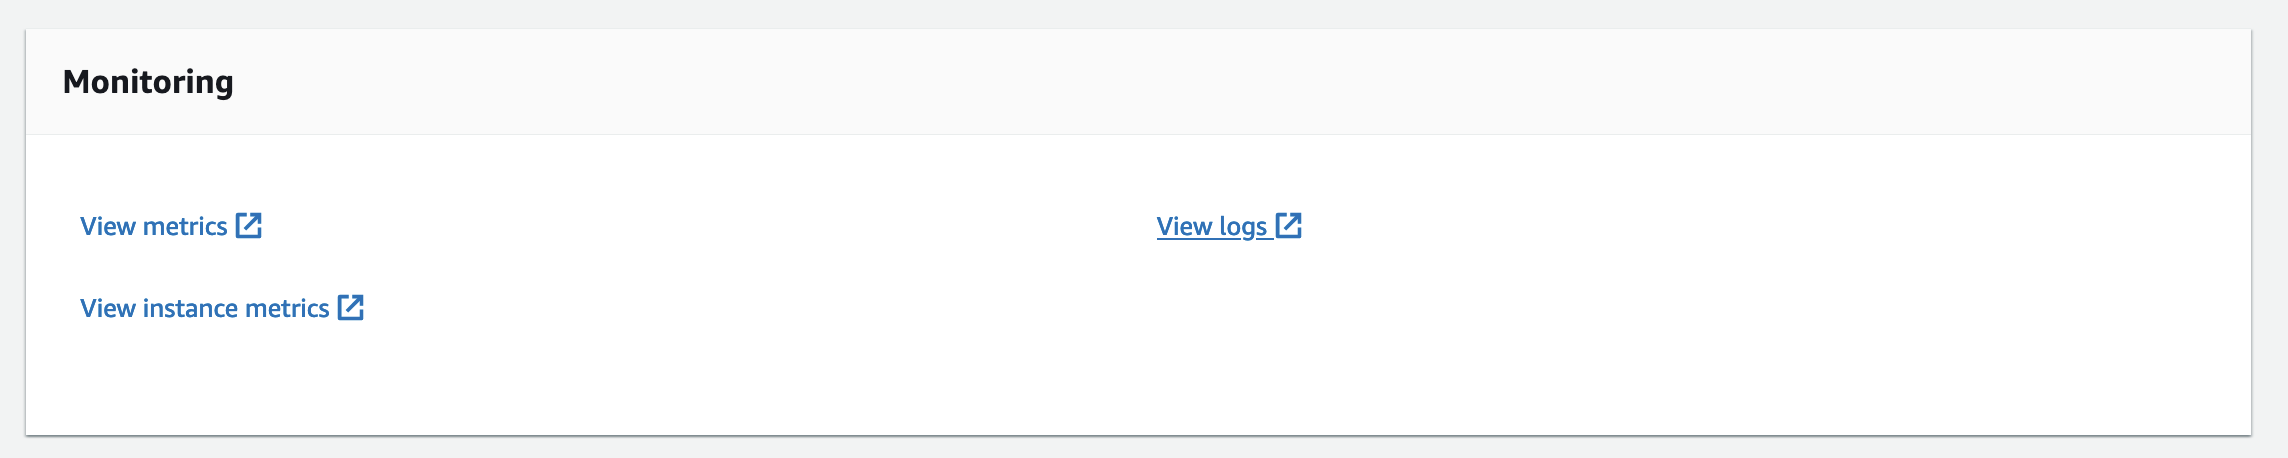

The job finishes after 15 mins
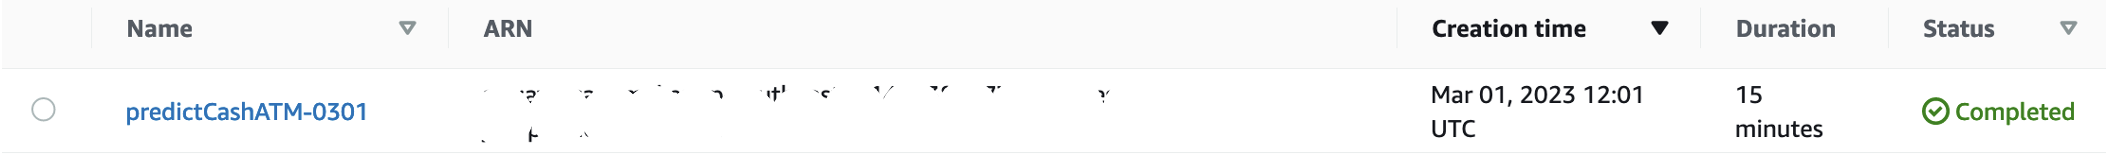